In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import pyresample as pr

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Load dataset

In [2]:
# Open dataset from file
ds_300 = xr.open_dataset('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/corr/0300.nc')
ds_700 = xr.open_dataset('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/corr/0700.nc')
ds_2000 = xr.open_dataset('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/corr/2000.nc')
ds_6000 = xr.open_dataset('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/corr/6000.nc')

In [6]:
# Add vertical and horizontal components of linear advection terms
ds_300['adv_Uanom_Tclim'] = ds_300.hadv_Uanom_Tclim+ds_300.vadv_Uanom_Tclim
ds_300['adv_Uclim_Tanom'] = ds_300.hadv_Uclim_Tanom+ds_300.vadv_Uclim_Tanom

ds_700['adv_Uanom_Tclim'] = ds_700.hadv_Uanom_Tclim+ds_700.vadv_Uanom_Tclim
ds_700['adv_Uclim_Tanom'] = ds_700.hadv_Uclim_Tanom+ds_700.vadv_Uclim_Tanom

In [7]:
# Merge datasets
ds_llc = xr.concat([ds_300, ds_700, ds_2000, ds_6000], pd.Index([300, 700, 2000, 6000], name='depth'))

In [8]:
ds_llc['adv'] = ds_llc.adv_Uanom_Tanom+ds_llc.adv_Uanom_Tclim+ds_llc.adv_Uclim_Tanom

In [9]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output')
coords_main = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

### Regridding
Regrid LLC dataset to regular 1/4 degree

In [10]:
# Extract LLC coordinates
lons_1d = coords_main.XC.values.reshape(np.product(coords_main.XC.values.shape))
lats_1d = coords_main.YC.values.reshape(np.product(coords_main.YC.values.shape)) 

# Define original grid
orig_grid = pr.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

# Spatial resolution
# Note: 1/4 degree is the default resolution in lon and lat to interpolate
dx = 0.25
dy = 0.25

# Longitudes latitudes to which we will we interpolate
lon_tmp = np.linspace(-180, 180, 360/dx)
lat_tmp = np.linspace(-89.5, 89.5, 90/dy)

# Define the lat lon points of the two parts.
new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
new_grid  = pr.geometry.GridDefinition(lons=new_grid_lon, lats=new_grid_lat)

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


### Map
Create raster of maps with
- columns: `varnames` (tite on top of each column: `varstrngs`)
- rows: `depth` (300, 700, 2000, 6000)

In [11]:
# Define custom colormap
cmap = plt.cm.RdBu_r
cmaplist = [cmap(i) for i in range(cmap.N)]

for x in range(round(cmap.N/2-cmap.N/20),round(cmap.N/2+cmap.N/20)):
    cmaplist[x] = (1,1,1,1.0)
    
cmap_custom = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [12]:
# Center of map
lon_cnt = -60

m = Basemap(projection='robin', lon_0=lon_cnt, resolution='c')
x,y = m(new_grid_lon, new_grid_lat) 

# Find index where data is splitted for mapping
split_lon_idx = round(x.shape[1]/(360/(lon_cnt if lon_cnt>0 else lon_cnt+360)))

In [13]:
varnames = ['hadv_Uanom_Tclim','vadv_Uanom_Tclim','hadv_Uclim_Tanom','vadv_Uclim_Tanom',
            'dif','frc','adv_Uanom_Tanom','res','adv_Uanom_Tclim','adv_Uclim_Tanom','adv']

varstrngs = [r'$\nabla_h(\mathbf{u}^{\prime}\overline{\theta}^m)$',
             r'$\frac{\partial}{\partial z}(w^{\prime}\overline{\theta}^m)$',
             r'$\nabla_h(\overline{\mathbf{u}}^m\theta^{\prime})$',
             r'$\frac{\partial}{\partial z}(\overline{w}^m\theta^{\prime})$',
             r'$\nabla{\mathbf{F_{diff}}^{\prime}}$',
             r'$F_{forc}^{\prime}$',
             r'$\nabla({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$',
             'Residual',
             r'$\nabla(\mathbf{u}^{\prime}\overline{\theta}^m)$',
             r'$\nabla(\overline{\mathbf{u}}^m\theta^{\prime})$',
             'Advection']

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/pyresample/kd_tree.py:563: RuntimeWarning: invalid value encountered in sqrt
  distance_upper_bound=radius_of_influence)
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


figure00_300_hadv_Uanom_Tclim
figure01_300_vadv_Uanom_Tclim
figure02_300_hadv_Uclim_Tanom
figure03_300_vadv_Uclim_Tanom
figure04_300_dif
figure05_300_frc
figure06_300_adv_Uanom_Tanom
figure07_300_res
figure08_300_adv_Uanom_Tclim
figure09_300_adv_Uclim_Tanom
figure010_300_adv
figure10_700_hadv_Uanom_Tclim
figure11_700_vadv_Uanom_Tclim
figure12_700_hadv_Uclim_Tanom
figure13_700_vadv_Uclim_Tanom
figure14_700_dif
figure15_700_frc
figure16_700_adv_Uanom_Tanom
figure17_700_res
figure18_700_adv_Uanom_Tclim


/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


figure19_700_adv_Uclim_Tanom
figure110_700_adv
figure20_2000_hadv_Uanom_Tclim
figure21_2000_vadv_Uanom_Tclim
figure22_2000_hadv_Uclim_Tanom
figure23_2000_vadv_Uclim_Tanom
figure24_2000_dif
figure25_2000_frc
figure26_2000_adv_Uanom_Tanom
figure27_2000_res
figure28_2000_adv_Uanom_Tclim
figure29_2000_adv_Uclim_Tanom
figure210_2000_adv
figure30_6000_hadv_Uanom_Tclim
figure31_6000_vadv_Uanom_Tclim
figure32_6000_hadv_Uclim_Tanom
figure33_6000_vadv_Uclim_Tanom
figure34_6000_dif
figure35_6000_frc
figure36_6000_adv_Uanom_Tanom
figure37_6000_res
figure38_6000_adv_Uanom_Tclim
figure39_6000_adv_Uclim_Tanom
figure310_6000_adv


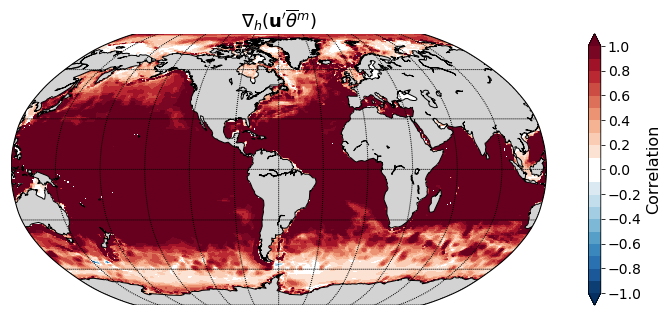

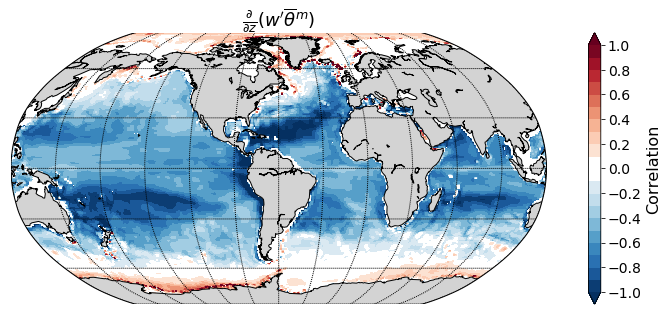

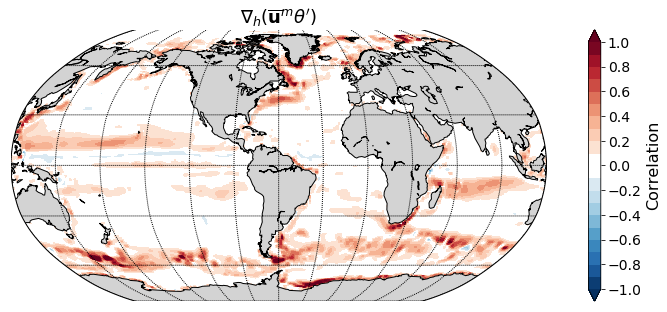

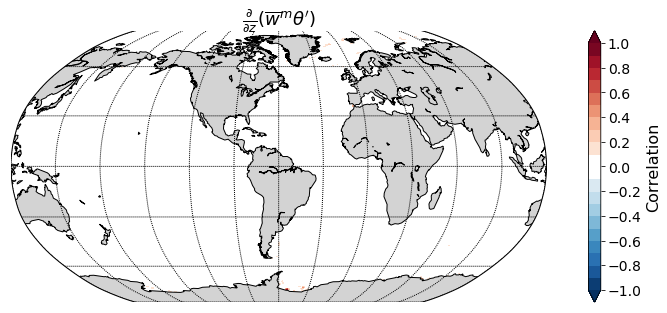

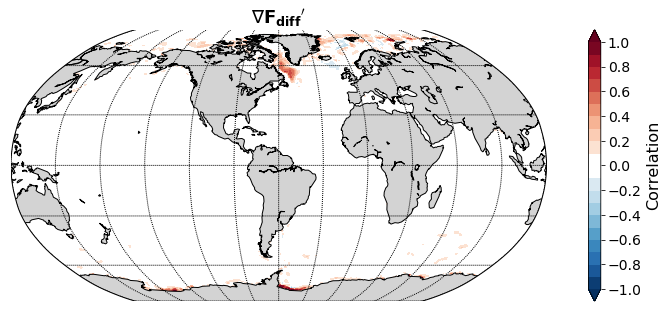

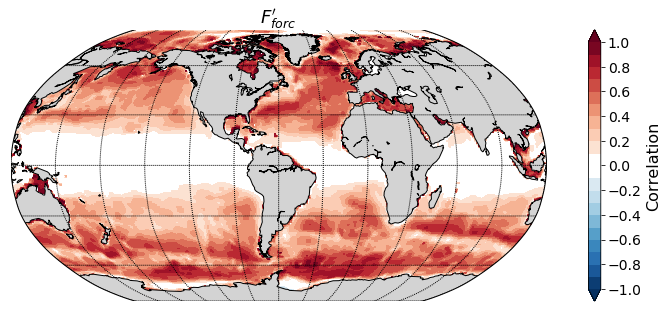

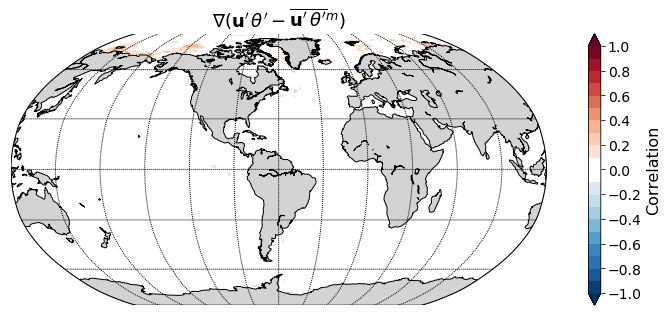

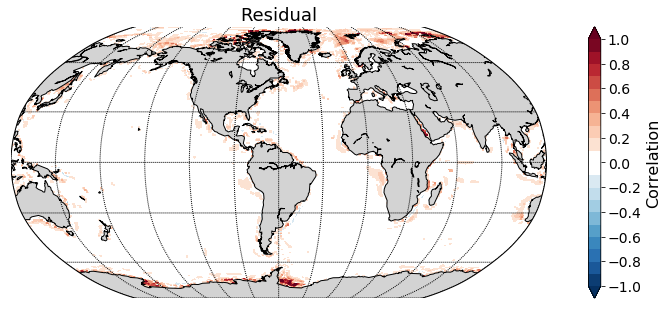

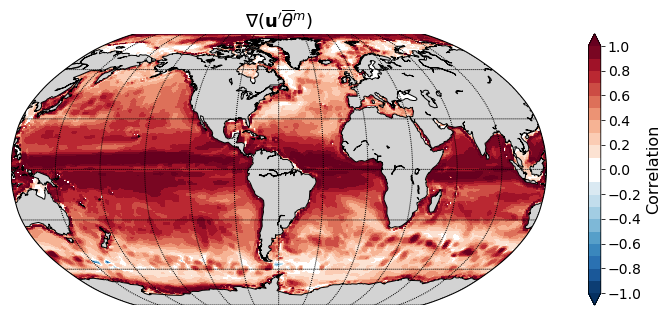

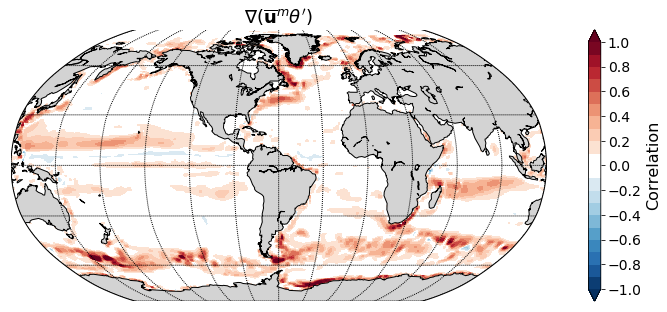

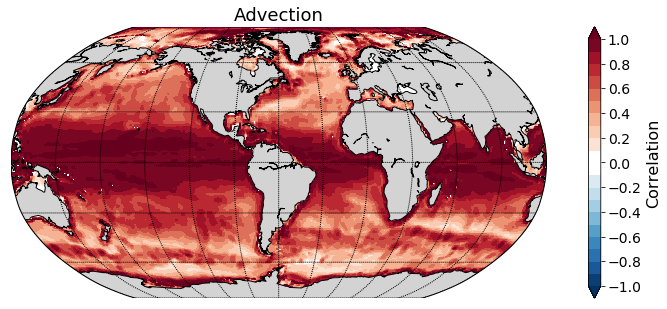

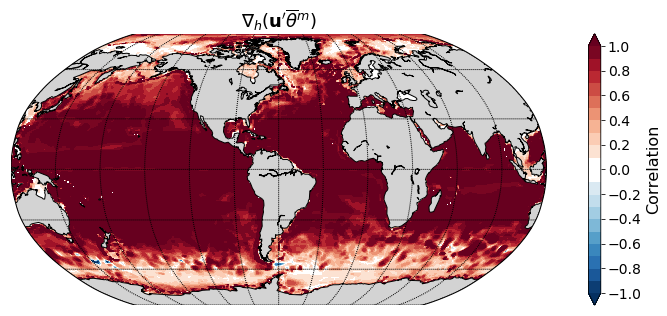

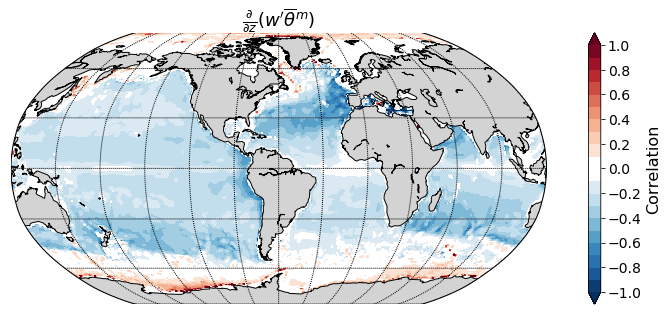

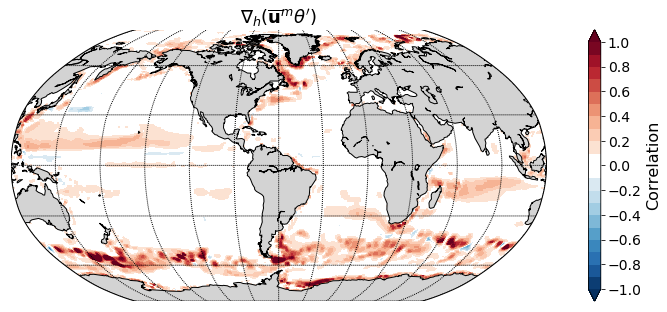

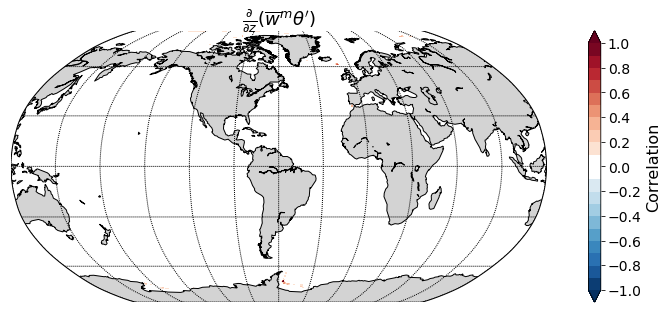

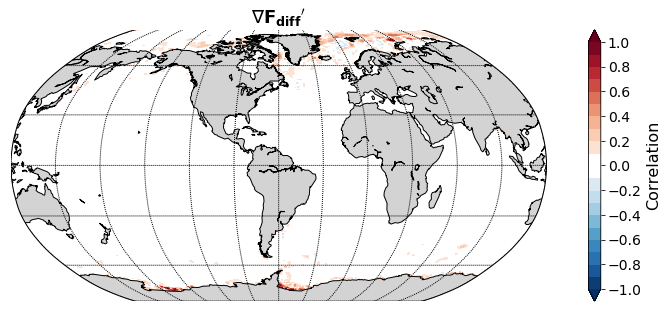

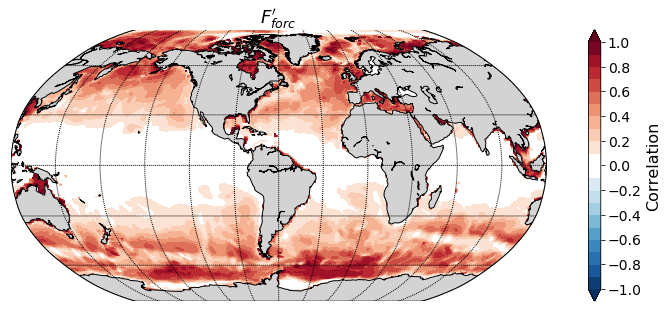

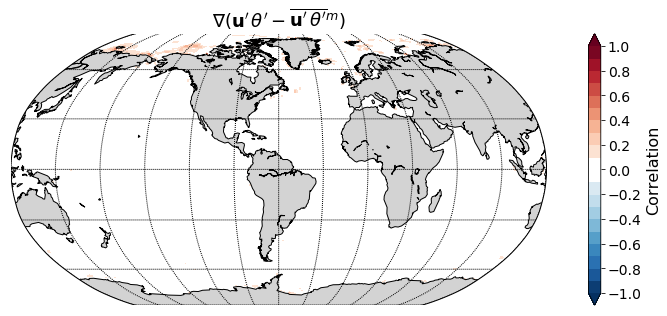

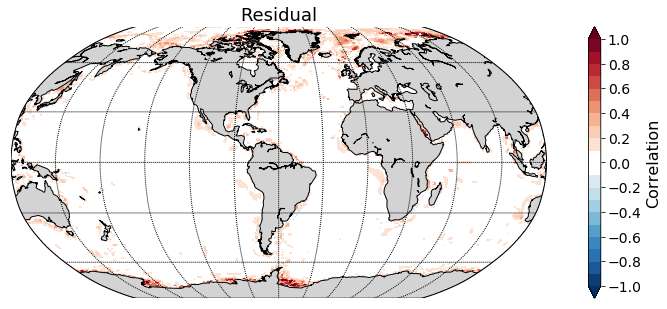

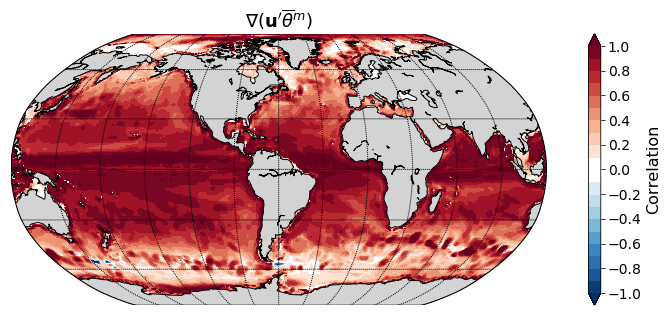

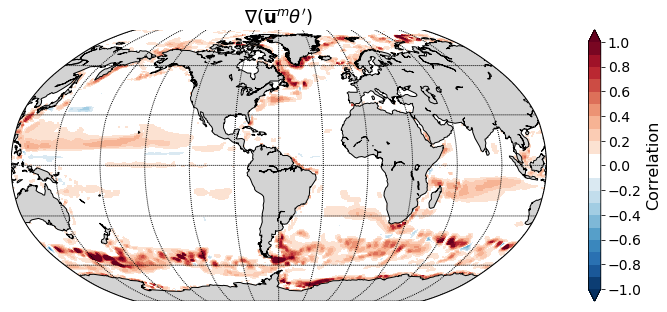

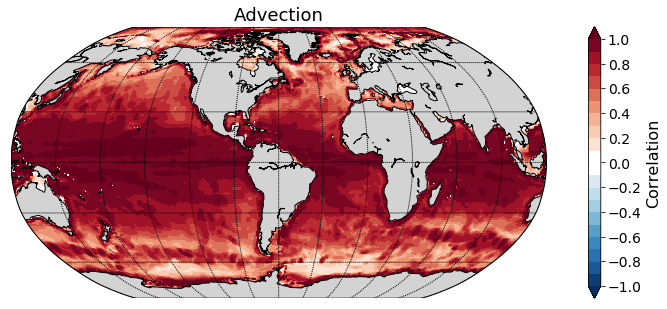

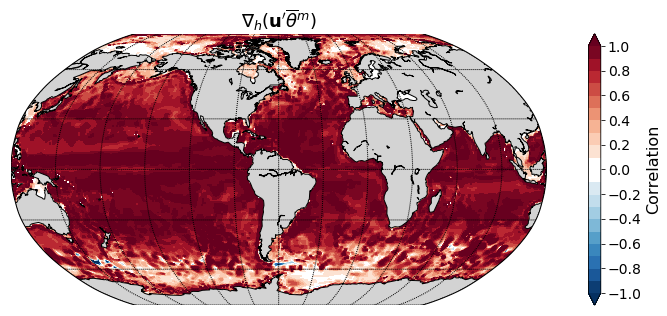

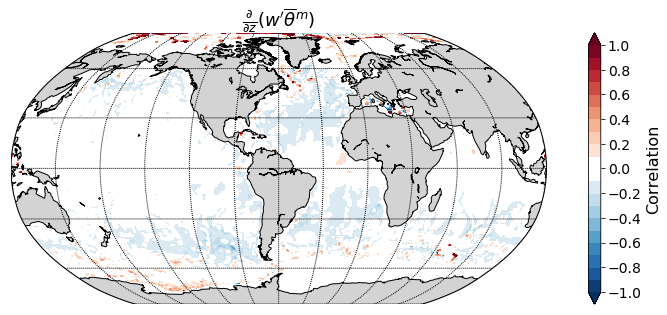

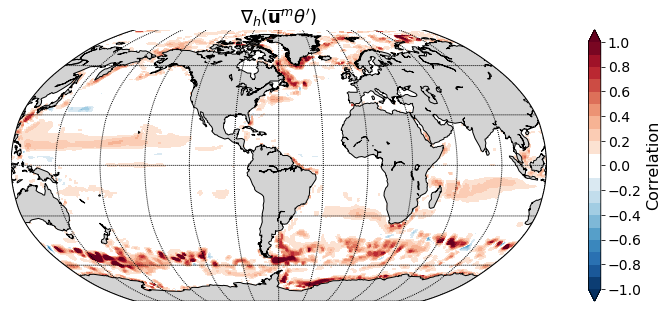

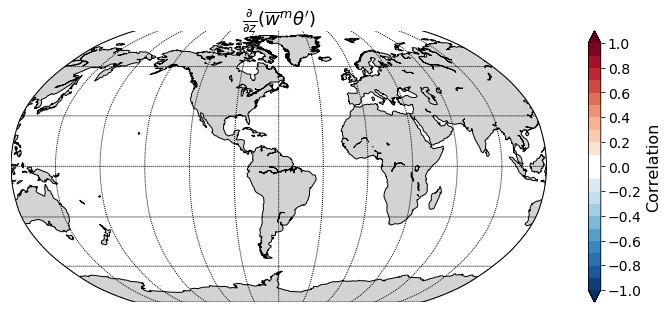

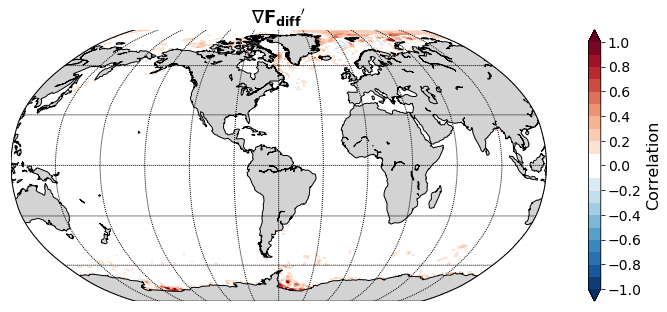

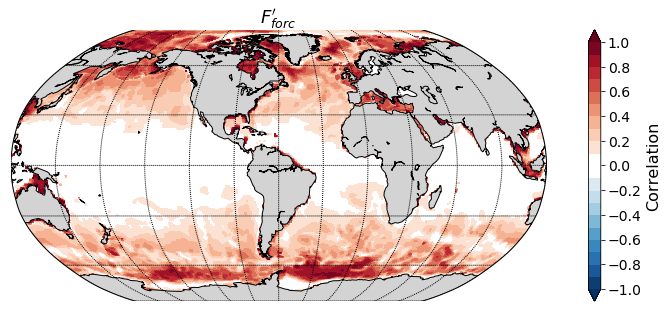

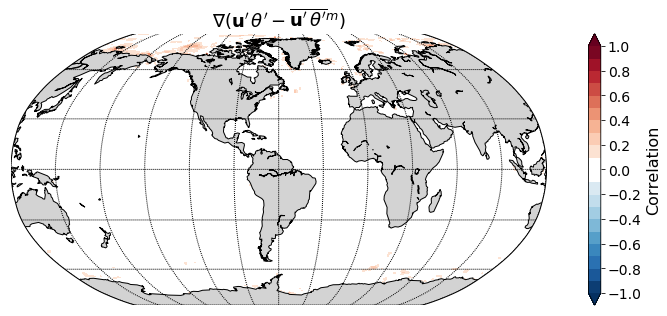

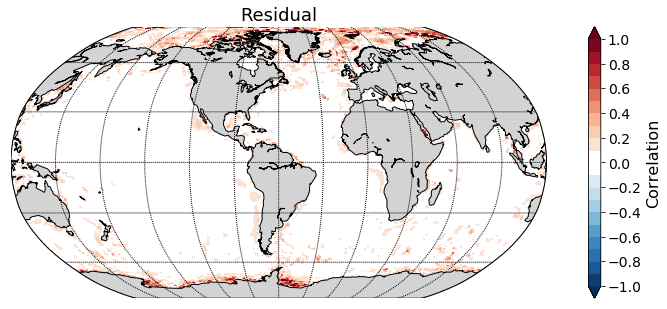

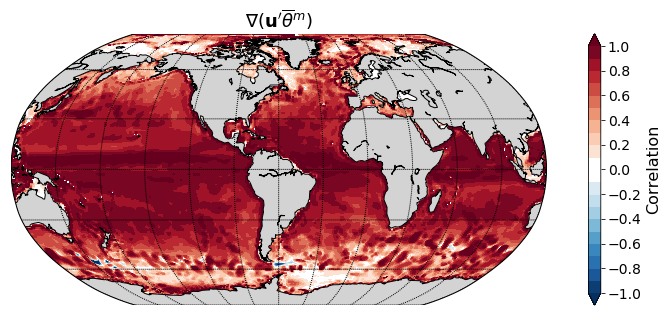

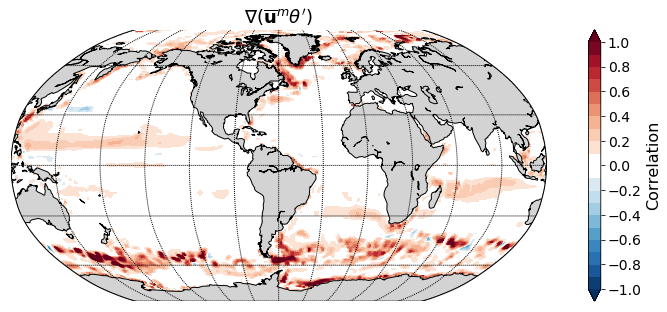

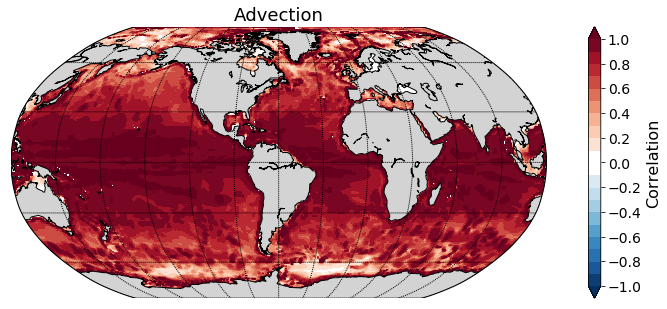

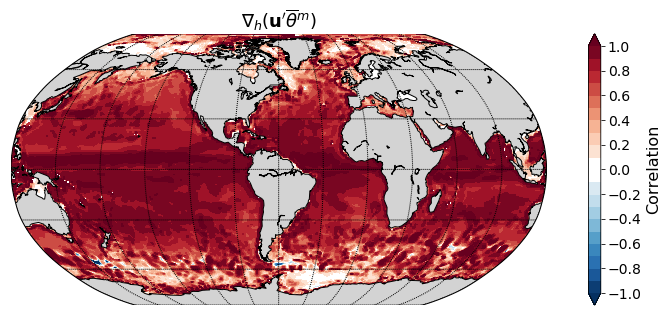

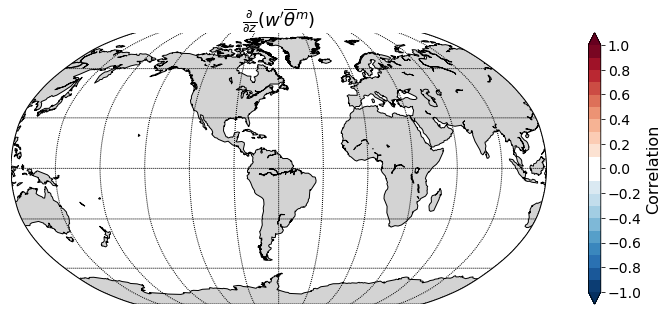

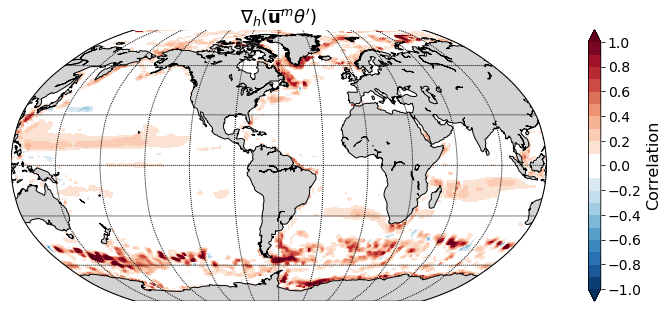

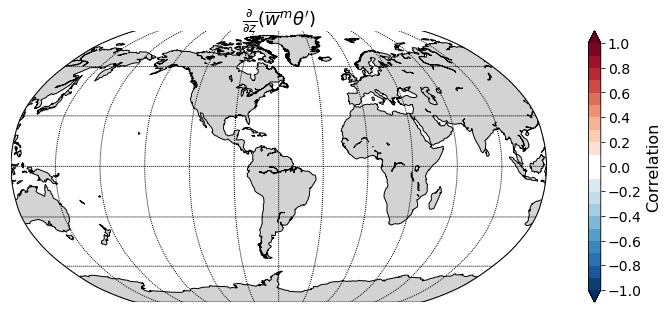

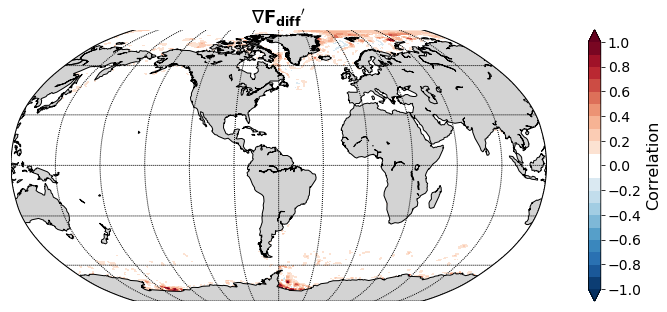

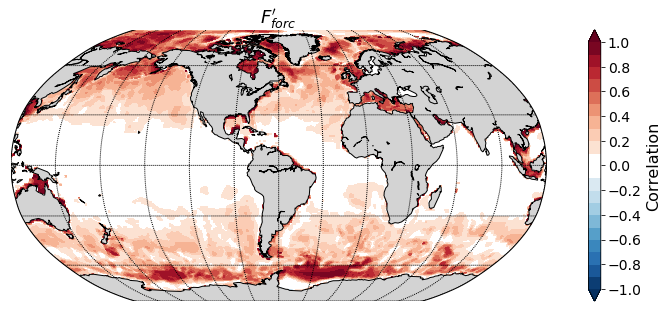

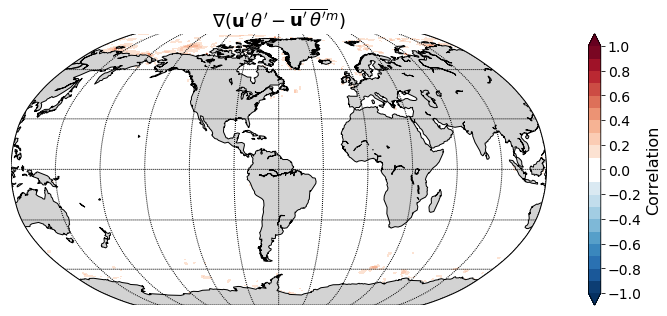

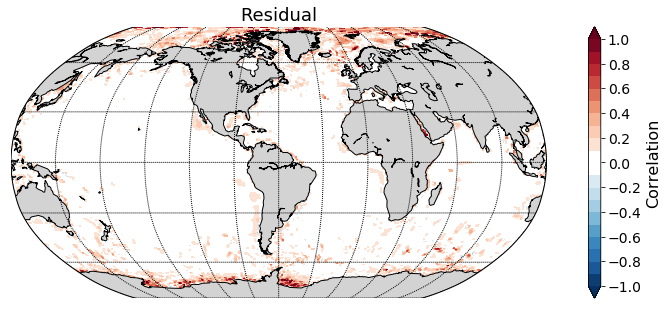

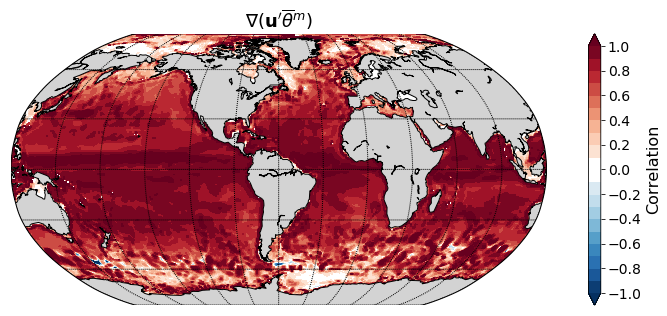

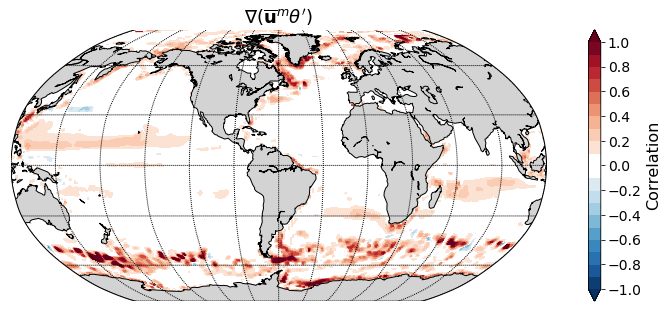

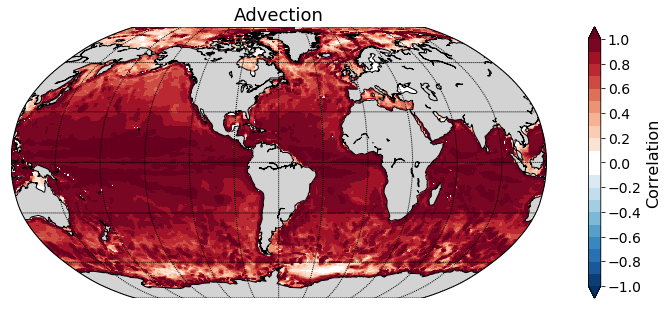

In [19]:
for jdx,dep in enumerate(ds_llc.depth.values):
    for idx,var in enumerate(varnames):
        
        field = pr.kd_tree.resample_nearest(orig_grid, ds_llc.sel(depth=dep)[var].values, 
                                            new_grid, radius_of_influence=100000, fill_value=None)
        
        fig = plt.figure(figsize=(15,5))
        
        m = Basemap(projection='robin', lon_0=lon_cnt, resolution='c')
        m.fillcontinents(color='lightgrey',lake_color='lightgray')
        m.drawcoastlines(linewidth=1)
        m.drawmeridians(np.arange(0,360,30))
        m.drawparallels(np.arange(-90,90,30))
        
        x,y = m(new_grid_lon, new_grid_lat)
        p = m.contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx], 21,
                       vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')
        p = m.contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:], 21, 
                       vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')
        plt.title(varstrngs[idx],fontsize=18)
        
        cb = fig.colorbar(p, ticks=np.arange(-1.0,1.2,0.2))
        cb.ax.tick_params(labelsize=14)
        cb.set_label(r'Correlation',fontsize=16)
        
        plt.savefig('/rigel/home/jt2796/corr_maps_aveZ/figure'+str(jdx)+str(idx)+'_'+str(dep)+'_'+varnames[idx]+'.png')
        plt.savefig('/rigel/home/jt2796/corr_maps_aveZ/figure'+str(jdx)+str(idx)+'_'+str(dep)+'_'+varnames[idx]+'.pdf')
        print('figure'+str(jdx)+str(idx)+'_'+str(dep)+'_'+varnames[idx])

In [17]:
field = pr.kd_tree.resample_nearest(orig_grid, ds_llc.sel(depth=300)['frc'].values, 
                                    new_grid, radius_of_influence=100000, fill_value=None)
idx = 5

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/pyresample/kd_tree.py:563: RuntimeWarning: invalid value encountered in sqrt
  distance_upper_bound=radius_of_influence)


/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


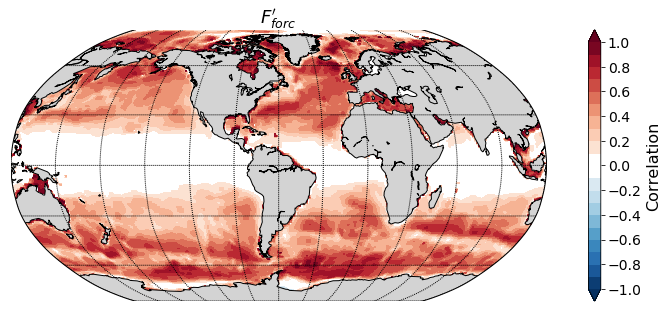

In [20]:
field = pr.kd_tree.resample_nearest(orig_grid, ds_llc.sel(depth=dep)[var].values, 
                                    new_grid, radius_of_influence=100000, fill_value=None)

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/pyresample/kd_tree.py:563: RuntimeWarning: invalid value encountered in sqrt
  distance_upper_bound=radius_of_influence)


/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


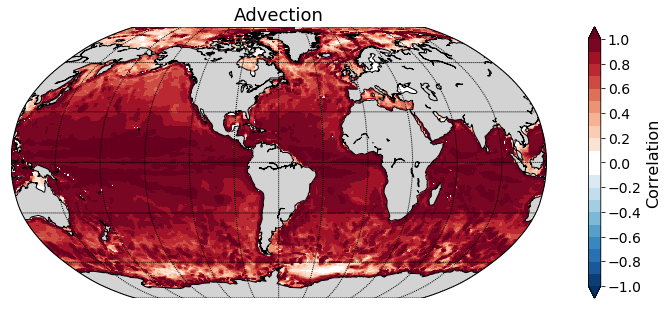

In [21]:
fig = plt.figure(figsize=(15,5))
        
m = Basemap(projection='robin', lon_0=lon_cnt, resolution='c')
m.fillcontinents(color='lightgrey',lake_color='lightgray')
m.drawcoastlines(linewidth=1)
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
        
x,y = m(new_grid_lon, new_grid_lat) 
p = m.contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx], 21,
               vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')
p = m.contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:], 21, 
               vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')
plt.title(varstrngs[idx],fontsize=18)
        
cb = fig.colorbar(p, ticks=np.arange(-1.0,1.2,0.2))
cb.ax.tick_params(labelsize=14)
cb.set_label(r'Correlation',fontsize=16)

plt.show()

### Put all into one figure

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


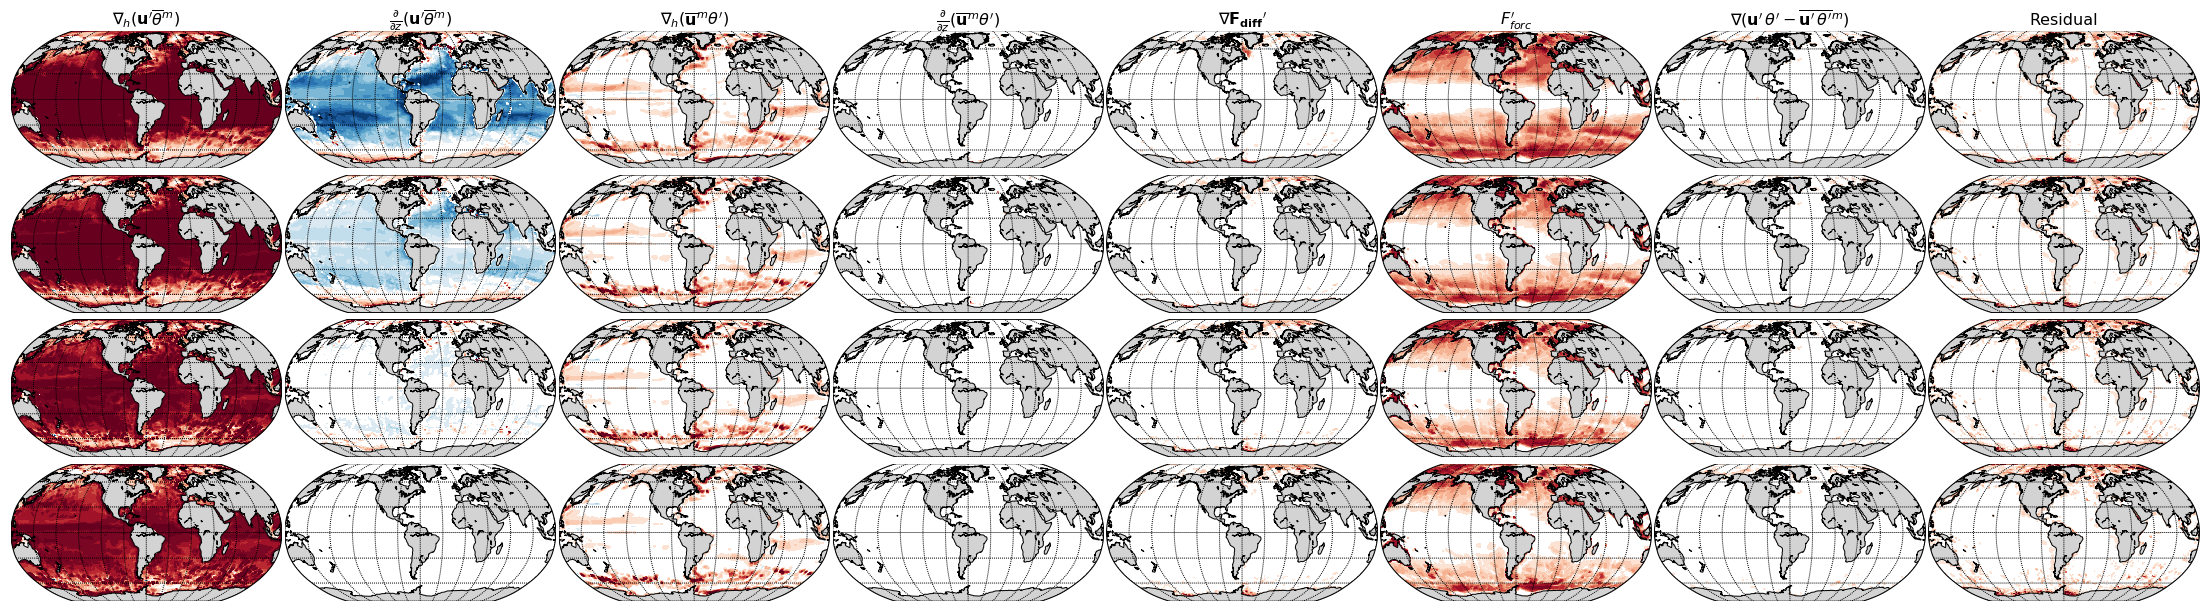

In [14]:
f, axs = plt.subplots(4, 8, figsize=(38,10))

for jdx,dep in enumerate(ds_llc.depth.values):
    for idx,var in enumerate(varnames):
        
        field = pr.kd_tree.resample_nearest(orig_grid, ds_llc.sel(depth=dep)[var].values, 
                                            new_grid, radius_of_influence=100000, fill_value=None)
        
        m = Basemap(projection='robin', lon_0=lon_cnt, resolution='c', ax=axs[jdx][idx])
        m.fillcontinents(color='lightgrey',lake_color='lightgray')
        m.drawcoastlines(linewidth=1)
        m.drawmeridians(np.arange(0,360,30))
        m.drawparallels(np.arange(-90,90,30))
        x,y = m(new_grid_lon, new_grid_lat) 
        p = m.contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx], 21, 
                       vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')
        p = m.contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:], 21, 
                       vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')
        
        if dep == 300:
            axs[jdx][idx].set_title(varstrngs[idx],fontsize=16)

f.tight_layout()
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.01, wspace = 0.01)

plt.savefig('/rigel/home/jt2796/figure.png')
plt.savefig('/rigel/home/jt2796/figure.eps')
plt.show()

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


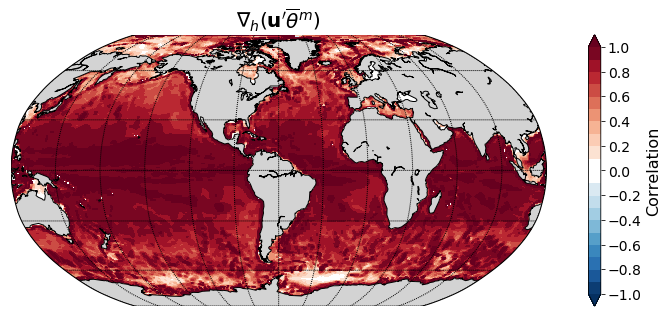

In [22]:
fig = plt.figure(figsize=(15,5))

m = Basemap(projection='robin', lon_0=lon_cnt, resolution='c')
m.fillcontinents(color='lightgrey',lake_color='lightgray')
m.drawcoastlines(linewidth=1)
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
p = m.contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx], 21,
               vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')
p = m.contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:], 21, 
               vmin=-1.0, vmax=1.0, cmap=cmap_custom, levels=np.linspace(-1.0, 1.0, 21), extend='both')

plt.title(r'$\nabla_h(\mathbf{u}^{\prime}\overline{\theta}^m)$',fontsize=20)

cb = fig.colorbar(p, ticks=np.arange(-1.0,1.2,0.2))
cb.ax.tick_params(labelsize=14)
cb.set_label(r'Correlation',fontsize=16)

plt.show()

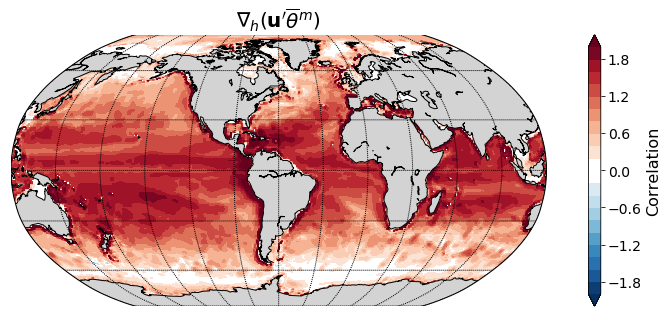

In [23]:
sum_of_corr = ds_llc.sel(depth=300)['hadv_Uanom_Tclim'] + ds_llc.sel(depth=300)['vadv_Uanom_Tclim'] +\
                ds_llc.sel(depth=300)['hadv_Uclim_Tanom'] + ds_llc.sel(depth=300)['vadv_Uclim_Tanom'] +\
                ds_llc.sel(depth=300)['dif'] + ds_llc.sel(depth=300)['frc'] +\
                ds_llc.sel(depth=300)['adv_Uanom_Tanom'] + ds_llc.sel(depth=300)['res']

field = pr.kd_tree.resample_nearest(orig_grid, sum_of_corr.values, new_grid, radius_of_influence=100000, 
                                    fill_value=None)

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/pyresample/kd_tree.py:563: RuntimeWarning: invalid value encountered in sqrt
  distance_upper_bound=radius_of_influence)


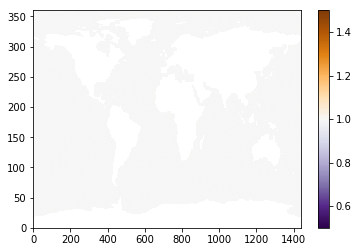

In [24]:
plt.pcolormesh(field,vmin=0.5,vmax=1.5,cmap='PuOr_r')
plt.colorbar()

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/colors.py:956: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


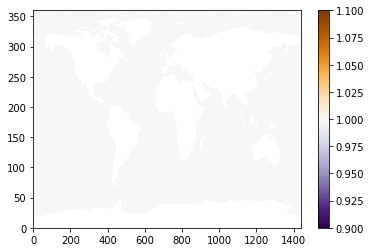

In [25]:
plt.pcolormesh(field,vmin=0.9,vmax=1.1,cmap='PuOr_r')
plt.colorbar()

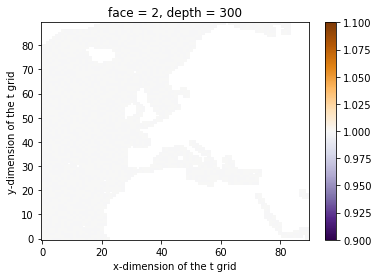

In [26]:
sum_of_corr[2].plot(vmin=0.9,vmax=1.1,cmap='PuOr_r')

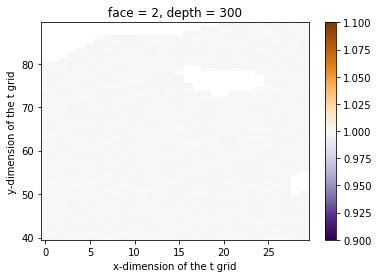

In [27]:
sum_of_corr[2,40:,:30].plot(vmin=0.9,vmax=1.1,cmap='PuOr_r')

In [28]:
sum_of_corr[2,42,10].values

array(1.00000005)